In [ ]:
# Install czmodel and dependencies
! pip install --upgrade pip
! pip install "torch==2.5.1"
! pip install "torchvision==0.20.1"
! pip install "czmodel[pytorch]>=5,<6"

In [1]:
# This can be used to switch on/off warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Simple PyTorch model for regression (to denoise the image)
This notebook shows the entire workflow of training an ANN with [PyTorch](https://pytorch.org/) using the Keras API and exporting the trained model to the [CZANN format](https://pypi.org/project/czmodel/) to be ready for use within the [Intellesis](https://www.zeiss.de/mikroskopie/produkte/mikroskopsoftware/zen-intellesis-image-segmentation-by-deep-learning.html) infrastructure.

* The trained model is rather simple (for demo purposes) and trained on a small test dataset.
* **Therefore, this notebook is meant to be understood as a guide for exporting trained models.**
* **The notebook does not provide instructions how to train a model correctly.**

## Imports

In [13]:
# Required imports to train a simple PyTorch model for regression and package it as CZANN.
# The CZANN can then be imported in ZEN and used for regression workflows (e.g. denoising).

# General imports
import os
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from typing import List

# Function provided by the PyPI package called czmodel (by ZEISS)
from czmodel import ModelMetadata, ModelType
from czmodel.pytorch import ModelSpec
from czmodel.pytorch import DefaultConverter

# Optional: suppress PyTorch warnings
import logging
logging.getLogger("pytorch").setLevel(logging.ERROR)
print(torch.__version__)

# Use GPU if available otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

2.5.1
cuda


## Training Pipeline
This section describes a simple training procedure that creates a trained Keras model.

* Therefore, it only represents the custom training procedure
* Such procedure will vary from case to case and will contain more sophisticated ways to generate an optimized Keras model

### Define parameters for data loading

In [4]:
# Folder containing the input images
IMAGES_FOLDER = 'Mouse_Kidney_images/images/'

# Folder containing the ground truth regression labels
# Regression labels contain a real number for each pixel
LABELS_FOLDER = 'Mouse_Kidney_images/labels/'

# Path to the data on GitHub
GITHUB_TRAINING_DATA_PATH = 'https://raw.githubusercontent.com/zeiss-microscopy/OAD/master/Machine_Learning/notebooks/Mouse_Kidney_images.zip'
GITHUB_MODEL_CONVERSION_SPEC_PATH = 'https://raw.githubusercontent.com/zeiss-microscopy/OAD/master/Machine_Learning/notebooks/regression_conversion_spec_pytorch.json'

# Define the number of input color channels
# This means that the inputs are grayscale with one channel only
CHANNELS = 1 

# The size of image crops to train the model with
CROP_SIZE = 512

### Download data if it's not available on disk
If this notebook is run e.g. as a colab notebook, it does not have access to the data folder on gitub via disk access. 
In that case we need to download the data from github first.

In [5]:
print(os.getcwd())

if not os.path.exists("models"):
  os.mkdir("models")
  print("Folder %s created!" % "models")
else:
  print("Folder %s already exists" % "models")

f:\Github\ZEN_Python_CZI_Smart_Microscopy_Workshop\workshop\notebooks
Folder models already exists


In [6]:
import requests

# Download training data
if not (os.path.isdir(IMAGES_FOLDER) and os.path.isdir(LABELS_FOLDER)):
    compressed_data = './Mouse_Kidney_images.zip'
    if not os.path.isfile(compressed_data):
        import io
        response = requests.get(GITHUB_TRAINING_DATA_PATH, stream=True)
        compressed_data = io.BytesIO(response.content)
        
    import zipfile
    with zipfile.ZipFile(compressed_data, 'r') as zip_accessor:
        zip_accessor.extractall('./')
        
# Download model conversion spec
if not os.path.isfile('./models/regression_conversion_spec_pytorch.json'):
    response = requests.get(GITHUB_MODEL_CONVERSION_SPEC_PATH, stream=True)
    with open('./models/regression_conversion_spec_pytorch.json', 'wb') as handle:
        handle.write(response.content)

### Define a PyTorch dataset to pre-process the images
Since the dataset contains very large images we need to train on smaller crops in order to not exhaust the GPU memory

In [7]:
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms.functional as TF
import cv2

# Dataset class
class SampleDataset(Dataset):
    def __init__(self, images_folder:str, labels_folder:str, transforms: torchvision.transforms=None):
        self.sample_images = sorted([os.path.join(images_folder, f) for f in os.listdir(images_folder) 
                                    if os.path.isfile(os.path.join(images_folder, f))])
        self.sample_labels = sorted([os.path.join(labels_folder, f) for f in os.listdir(labels_folder) 
                                    if os.path.isfile(os.path.join(labels_folder, f))])
        self.transforms = transforms

    def __getitem__(self, idx: int):
        image = self.sample_images[idx]
        label = self.sample_labels[idx]
        img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        labl = cv2.imread(label, cv2.IMREAD_GRAYSCALE) 

        if self.transforms is not None:
            img = self.transforms(img)
            labl = self.transforms(labl)
            
        # Randomly crop the image
        i, j, h, w = torchvision.transforms.RandomCrop.get_params(img, output_size=(CROP_SIZE, CROP_SIZE))
        img = TF.crop(img, i, j, h, w)
        labl = TF.crop(labl, i, j, h, w)

        return img.to(torch.float32), labl.to(torch.float32)

    def __len__(self):
        return len(self.sample_images)

In [8]:
# Define transforms
from torchvision import transforms
transforms = transforms.Compose([
    transforms.ToTensor(),
])

# Create dataset and dataloader
sample_dataset = SampleDataset(images_folder=IMAGES_FOLDER,
                               labels_folder=LABELS_FOLDER,
                               transforms=transforms)

sample_dataloader = DataLoader(dataset=sample_dataset,
                                      batch_size=2,
                                      shuffle=True)

### Define a simple model
This part defines a simple PyTorch convolutional model for regression task.

In [9]:
# Define simple PyTorch convolutional model
class SampleModel(nn.Module):

    def __init__(self):
        super(SampleModel, self).__init__()
        self.model = nn.Sequential(
            # Encoder
            nn.Conv2d(1, 16, 3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2, padding=0),
            nn.Conv2d(16, 16, 3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2, padding=0),
            nn.Conv2d(16, 16, 3, padding=1),  
            nn.ReLU(),
            # Decoder
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(16, 16, 3, padding=1),  
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(16, 1, 3, padding=1),              
        )

    def forward(self, x: torch.Tensor):
        x = self.model(x)
        return x


model = SampleModel().to(device)

### Training the model with the loaded data
This part fits the model to the loaded data. In this test example we do not care about an actual evaluation of the model using validation and test datasets.

In [10]:
# Define the number of training epochs
NUM_EPOCHS = 20

# Define loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, eps=1e-08)

In [11]:
def train_one_epoch(epoch_index: int):
    running_loss = 0.

    for i, data in enumerate(sample_dataloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()
        running_loss += loss.item()

    return running_loss

In [14]:
# Define plotting function
def plot_history(loss: List):
    plt.plot(loss)
    plt.title('training loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

Epoch 1, loss 3.757225e-01
Epoch 2, loss 1.529001e-01
Epoch 3, loss 1.247626e-01
Epoch 4, loss 8.795097e-02
Epoch 5, loss 4.437753e-02
Epoch 6, loss 3.237441e-02
Epoch 7, loss 2.560847e-02
Epoch 8, loss 1.967764e-02
Epoch 9, loss 1.662593e-02
Epoch 10, loss 1.432190e-02
Epoch 11, loss 1.211829e-02
Epoch 12, loss 1.129522e-02
Epoch 13, loss 1.071308e-02
Epoch 14, loss 1.060886e-02
Epoch 15, loss 1.018762e-02
Epoch 16, loss 9.520819e-03
Epoch 17, loss 9.967166e-03
Epoch 18, loss 9.050777e-03
Epoch 19, loss 9.024954e-03
Epoch 20, loss 8.283515e-03


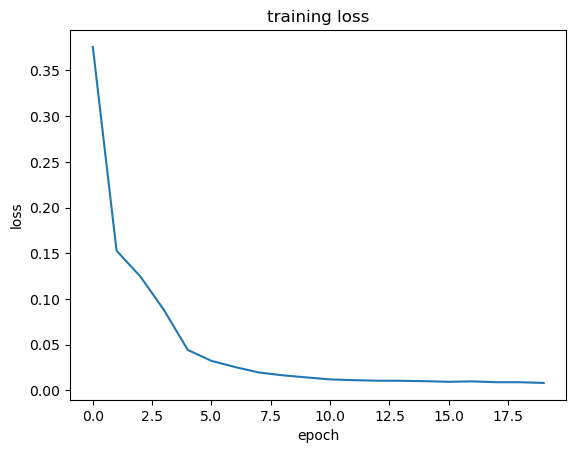

In [15]:
training_loss = []
for epoch in range( NUM_EPOCHS):
    loss = train_one_epoch(epoch)
    training_loss.append(loss)
    print(f'Epoch {epoch+1}, loss %2e'%(loss))

# Plot the training history
plot_history(training_loss)

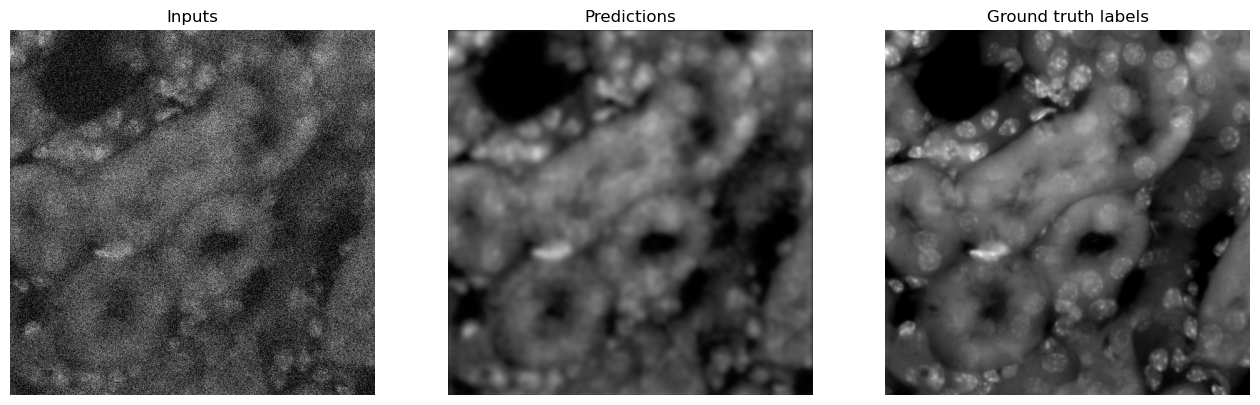

In [16]:
# Plot the training results
images_labels  = next(iter(sample_dataloader))
image, label = images_labels

plt.figure(figsize=(16,16))
# Plot the inputs
plt.subplot(1,3,1)
plt.axis('off')
plt.title('Inputs')
plt.imshow(image[0, 0, ...], cmap='gray')

# Plot the predictions
prediction = model(image.to(device))
plt.subplot(1,3,2)
plt.axis('off')
plt.title('Predictions')
plt.imshow(prediction.cpu().detach().numpy()[0, 0, ...], cmap='gray')

# Plot the ground truth labels
plt.subplot(1,3,3)
plt.axis('off')
plt.title('Ground truth labels')
plt.imshow(label[0, 0, ...], cmap='gray')
plt.show()

In [17]:
# Move the model to cpu
PATH = './saved_torch_regression_model.pt'
model.cpu()
torch.save(model, PATH)

## Create a CZANN from the trained PyTorch model
In this section we export the trained model to the CZANN format using the czmodel library and some additional meta data. All possible parameter choices are described in the [ANN model specification](https://pypi.org/project/czmodel/).

### Define Meta Data
We first define the meta data needed to run the model within the Intellesis infrastructure. The `czmodel` package offers a named tuple `ModelMetadata` that allows to either parse as JSON file as described in the [specification document](https://pypi.org/project/czmodel/) or to directly specify the parameters as shown below.

### Create a Model Specification Object
The export functions provided by the `czmodel` package expect a `ModelSpec` tuple that features the Keras model to be exported, the corresponding model meda data and optionally a license file for the model.

Therefore, we wrap our model and the `model_metadata` instance into a `ModelSpec` object.

In [18]:
# Define dimensions - ZEN Intellesis requires fully defined spatial dimensions in the meta data of the CZANN model.
# The ZEN TilingClient uses the input shape in the meta data to infer the tile size to pass an image to the inferencer.
# Important: The tile size has to be chosen s.t. inference is possible with the minimum hardware requirements of Intellesis
# Optional: Define target spatial dimensions of the model for inference.
input_size = 512

# Define the model metadata
model_metadata = ModelMetadata(
    input_shape=[input_size, input_size, CHANNELS],
    output_shape=[input_size, input_size, CHANNELS],
    model_type=ModelType.REGRESSION,
    model_name="Simple_Kidney_RegressionModel",
    min_overlap=[8, 8],
    scaling=(1.0, 1.0),
)

model_spec = ModelSpec(
    model=model,
    model_metadata=model_metadata,
    license_file=None
)

### Perform model export into *.czann  file format

The converters from the `czmodel` library offers two functions to perform the actual export. 

* `convert_from_json_spec` allows to provide a JSON file containing all the information of a ModelSpec object and converts a model in SavedModel format on disk to a `.czann` file that can be loaded with ZEN.
* `convert_from_model_spec` expects a `ModelSpec` object, an output path and name and optionally target spatial dimensions for the expected input of the exported model. From this information it creates a `.czann`  file containing the specified model.

Currently, `czmodel` offers one converter for a regression model:
* DefaultConverter: Converts a model to a *.czann file.

In [19]:
DefaultConverter().convert_from_model_spec(
    model_spec=model_spec, 
    output_path='./models', 
    output_name='simple_pytorch_kidney_regmodel',
    input_shape=(CHANNELS, input_size, input_size),
)

# In the example above there will be a ""./models/simple_pytorch_kidney_regmodel.czann" file saved on disk.

## Remarks
The generated .czann file can be directly loaded into ZEN Intellesis to perform regression tasks with the trained model.
If there is already a trained model in SavedModel format present on disk, it can also be converted by providing the path to the saved model directory instead of a PyTorch `Module` object. The `czmodel` library will implicitly load the model from the provided path.

The `czmodel` library also provides a `convert_from_json_spec` function that accepts a JSON file with the above mentioned meta data behind the key `ModelMetadata` which will implicitly be deserialized into a `ModelMetadata` object, the model path and optionally a license file:
```json
{
    "ModelMetadata": {
        "Type": "Regression",
        "InputShape": [512, 512, 1],
        "OutputShape": [512, 512, 1],
        "ModelName": "Regression Model From JSON",
        "MinOverlap": [8, 8],
        "Scaling": [1.0, 1.0]
    },
    "ModelPath": "./models/saved_torch_regression_model.pt",
    "LicenseFile": null
}
```

This information can be copied to a file e.g. in the current working directory `./models/model_conversion_spec.json` that also contains the trained model in SavedModel format e.g. generated by the following line:

In [20]:
# This is an additional way to create a CZANN from a saved PyTorch model on disk + JSON file.
# The currently recommended way to to create the CZANN directly by using czmodel.convert_from_model_spec
# the path to the saved Pytorch is defined in the JSON shown above

DefaultConverter().convert_from_json_spec(
    model_spec_path='./models/regression_conversion_spec_pytorch.json',
    output_path='./models',
    output_name = 'simple_kidney_regmodel_from_json_pytorch',
    input_shape=(CHANNELS, input_size, input_size),
)

Use the commands below from a terminal to present the notebook as a slideshow.

`
jupyter nbconvert Regression_PyTorch.ipynb --to slides --post serve
    --SlidesExporter.reveal_theme=serif 
    --SlidesExporter.reveal_scroll=True 
    --SlidesExporter.reveal_transition=none
`